**Here, we are going to replicate the VolGAN-example file, by demonstrating the modifications we are making to the VolGAN file and introducing new functions we have created.**

In [1]:
#import libraries

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
import torch.nn as nn
warnings.filterwarnings("ignore")

#import files with supporting functions
import VolGAN
import Inputs

#import our data sets and a sample date for testing
datapath = "data/swaption_atm_vol_full.xlsx"
surfacepath = "data/forward_sofr_swap_full.xlsx"
sampledate = datetime(2025, 1, 10, 0, 0, 0)

**Below are some of the new functions from the Inputs file**

NOTE: I can't  get the plot functions to work, nor tabular_rvol_form (for some bizzare reason)

In [2]:
#original file showing volatility
datapath_df = Inputs.read_excel_default(datapath)
datapath_df.head()

,1M,1M.1,1M.2,1M.3,1M.4,1M.5,1M.6,1M.7,1M.8,3M,...,25Y.8,30Y,30Y.1,30Y.2,30Y.3,30Y.4,30Y.5,30Y.6,30Y.7,30Y.8
TERM (TENOR),,,,,,,,,,,,,,,,,,,,,
MATRUITY (EXPIRY),1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,1Y,...,9Y,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y
Ticker,USSNAA1 ICPL Curncy,USSNAA2 ICPL Curncy,USSNAA3 ICPL Curncy,USSNAA4 ICPL Curncy,USSNAA5 ICPL Curncy,USSNAA6 ICPL Curncy,USSNAA7 ICPL Curncy,USSNAA8 ICPL Curncy,USSNAA9 ICPL Curncy,USSNAC1 ICPL Curncy,...,USSNA259 ICPL Curncy,USSNA301 ICPL Curncy,USSNA302 ICPL Curncy,USSNA303 ICPL Curncy,USSNA304 ICPL Curncy,USSNA305 ICPL Curncy,USSNA306 ICPL Curncy,USSNA307 ICPL Curncy,USSNA308 ICPL Curncy,USSNA309 ICPL Curncy
2025-01-10 00:00:00,72.2,96.8,97.7,99.9,101.6,100.5,99.5,99.1,98.6,88.9,...,70.3,73.9,75,74.2,73.2,72.1,71.1,69.8,68.6,67.1
2025-01-09 00:00:00,79.9,101.1,102.2,103.3,104.5,103.2,101.8,101.3,100.8,88.5,...,69.7,73.1,74.2,73.5,72.4,71.4,70.4,69.1,67.9,66.4
2025-01-08 00:00:00,80.9,101.7,102.9,104,105.2,103.9,102.5,102,101.5,87.1,...,69.8,73.2,74.3,73.6,72.6,71.5,70.5,69.2,68,66.5


In [3]:
#tenor and maturity dataframe by security
mat_ten_df = Inputs.maturity_tenor(filename=datapath)
mat_ten_df

1,USSNAA1 ICPL Curncy,USSNAA2 ICPL Curncy,USSNAA3 ICPL Curncy,USSNAA4 ICPL Curncy,USSNAA5 ICPL Curncy,USSNAA6 ICPL Curncy,USSNAA7 ICPL Curncy,USSNAA8 ICPL Curncy,USSNAA9 ICPL Curncy,USSNAC1 ICPL Curncy,...,USSNA259 ICPL Curncy,USSNA301 ICPL Curncy,USSNA302 ICPL Curncy,USSNA303 ICPL Curncy,USSNA304 ICPL Curncy,USSNA305 ICPL Curncy,USSNA306 ICPL Curncy,USSNA307 ICPL Curncy,USSNA308 ICPL Curncy,USSNA309 ICPL Curncy
Ticker,,,,,,,,,,,,,,,,,,,,,
Tenor,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.25,...,25.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
Mat,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,1.00,...,9.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0


In [4]:
#volatility, tenor, and maturity dataframe for a specific date by security
vol_df = Inputs.volatility_data(date=sampledate,filename=datapath)
vol_df.head()

,Values,Tenor,Maturity
USSNAA1 ICPL Curncy,72.2,0.083333,1.0
USSNAA2 ICPL Curncy,96.8,0.083333,2.0
USSNAA3 ICPL Curncy,97.7,0.083333,3.0
USSNAA4 ICPL Curncy,99.9,0.083333,4.0
USSNAA5 ICPL Curncy,101.6,0.083333,5.0


In [5]:
#repivoting the volatility data
tab_vol_df = Inputs.tabular_volatility_form(date=sampledate,filename=datapath)
tab_vol_df.head()

Maturity,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Tenor,,,,,,,,,
0.083333,72.2,96.8,97.7,99.9,101.6,100.5,99.5,99.1,98.6
0.250000,88.9,107.0,107.8,107.8,107.8,105.8,104.9,103.7,102.8
0.500000,102.2,110.8,109.6,108.9,108.2,106.5,105.1,103.9,103.0
0.750000,112.0,114.2,111.7,110.3,108.8,107.1,105.7,104.5,103.7
1.000000,117.7,116.0,112.4,110.2,108.4,106.7,105.4,104.3,103.5


In [6]:
#returns, tenor, and maturity dataframe for a specific date by security
returns_df = Inputs.returns_data(date=sampledate,filename=surfacepath)
returns_df.head()

,Values,Tenor,Maturity
S0042FS 1Y1M BLC Curncy,0.1513,0.083333,1.0
S0042FS 2Y1M BLC Curncy,0.1457,0.083333,2.0
S0042FS 3Y1M BLC Curncy,0.1087,0.083333,3.0
S0042FS 4Y1M BLC Curncy,0.0682,0.083333,4.0
S0042FS 5Y1M BLC Curncy,0.0475,0.083333,5.0


In [7]:
#repivoting the returns data
tab_returns_df = Inputs.tabular_returns_form(date=sampledate,filename=surfacepath)
tab_returns_df.head()

Maturity,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Tenor,,,,,,,,,
0.083333,0.1513,0.1457,0.1087,0.0682,0.0475,0.0335,0.0186,0.0010,-0.0103
0.250000,0.1522,0.1488,0.1049,0.0671,0.0470,0.0329,0.0173,-0.0005,-0.0131
0.500000,0.1538,0.1509,0.1046,0.0674,0.0472,0.0331,0.0173,-0.0011,-0.0140
0.750000,0.1602,0.1526,0.1057,0.0680,0.0477,0.0334,0.0174,-0.0013,-0.0144
1.000000,0.1643,0.1543,0.1059,0.0686,0.0482,0.0340,0.0176,-0.0006,-0.0155


In [8]:
#realized volatility, tenor, and maturity dataframe for a specific date by security
realized_vol_df = Inputs.realized_volatility_data(date=sampledate,nperiods=20,ann = 252,filename=surfacepath)
realized_vol_df.head()

,Values,Tenor,Maturity
S0042FS 1Y1M BLC Curncy,0.916704,0.083333,1.0
S0042FS 2Y1M BLC Curncy,0.899016,0.083333,2.0
S0042FS 3Y1M BLC Curncy,0.888737,0.083333,3.0
S0042FS 4Y1M BLC Curncy,0.911696,0.083333,4.0
S0042FS 5Y1M BLC Curncy,0.763827,0.083333,5.0


**Next, we will take a look at some of the VolGAN functions we are reworking.**

In [9]:
import VolGANSwaps as VGS

**Data Loading**
- The data loader takes in the filepath to the volatility surface and the forward swap rates
- Constructs returns on underlying
- Processes the volatility data
    - The surface for every underlying asset is represented as a vector
    - This is similarly the case for the returns
- Sets up the tenor and tau matrices

In [10]:
DATA_PATH = "data/swaption_atm_vol_no30y.xlsx"
SURFACE_PATH = "data/forward_sofr_swap_no30y.xlsx"

surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(DATA_PATH, SURFACE_PATH)

**Data Preprocessing**
- Within `DataPreprocessing` we call `SwapsData` like the original VolGAN implementation
- Here we construct the condition vector, construct the true labels and pass through some other data that might be relevant
    - Each underlying has a condition vector and the true labels (annualized return and log implied vol increment)
    - Because of this they will actually end up being tensor inputs to the models

In [11]:
# Data preprocessing example

true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(DATA_PATH, SURFACE_PATH, vol_model='normal')

In [12]:
true.shape

(484, 135, 2)

In [13]:
condition.shape

(484, 135, 4)

**Data Train Test Split**
- Separates dataset into train and test datasets after processing and loading
- Parameterized by datasize percentage / proportion
- Parameterized by volatility model assumption ('normal': Bachelier or 'log': Black)

In [14]:
true_train, true_test, condition_train,  condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(DATA_PATH, SURFACE_PATH, 0.8, vol_model='normal')

In [15]:
true_train.shape

torch.Size([387, 135, 2])

In [16]:
true_test.shape

torch.Size([97, 135, 2])

In [17]:
condition_train.shape

torch.Size([387, 135, 4])

In [18]:
condition_test.shape

torch.Size([97, 135, 4])

**Next, we are going to run the model.**
- We updated the two training loops in the paper by ensuring the dimensionality of the computations were correct
- We also accounted for the fact that we are using the normal model
- If desired, we can still utilize 

In [19]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
device = 'cpu'
n_epochs = 10000
n_grad = 25
val = True
vol_model = 'normal'
test_epoch = 100

We present training for a low number of epochs to ensure that the loops work.
- Output of this volgan function provides us set of data used to train the models
- Also `gen` and `disc` are the trained models that we can then evaluate once trained for more epochs

In [20]:
gen, gen_opt, disc, disc_opt, true_train, true_val, true_test, condition_train, condition_val, condition_test, dates_t,  tenor, tau, tenors, taus  = VGS.VolGAN(DATA_PATH,SURFACE_PATH, tr, noise_dim = noise_dim, hidden_dim = hidden_dim, n_epochs = test_epoch,n_grad = n_grad, lrg = 0.0001, lrd = 0.0001, batch_size = 100, device = 'cpu', vol_model=vol_model)

100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


alpha : 2.589696790567429e-06 beta : 0.0007070396998739555


100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


Visualize the results from the Gradient Matching

In [26]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
device = 'cpu'
n_epochs = 10000
n_grad = 250
val = True
vol_model = 'normal'
lrg = 0.0001 
lrd = 0.0001 
batch_size = 100 
device = 'cpu'

true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(DATA_PATH, SURFACE_PATH, tr, vol_model, device)
gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lrg)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

100%|██████████| 250/250 [00:36<00:00,  6.93it/s]


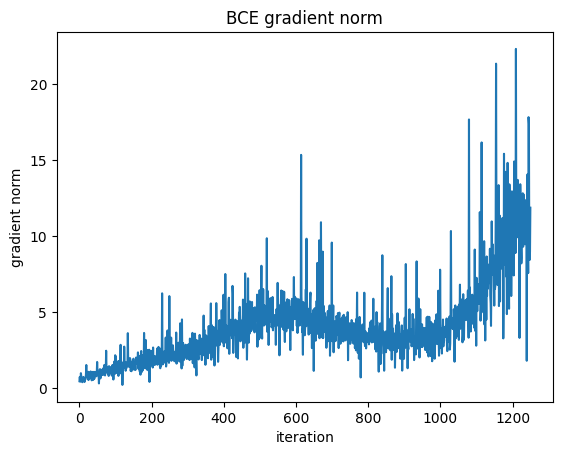

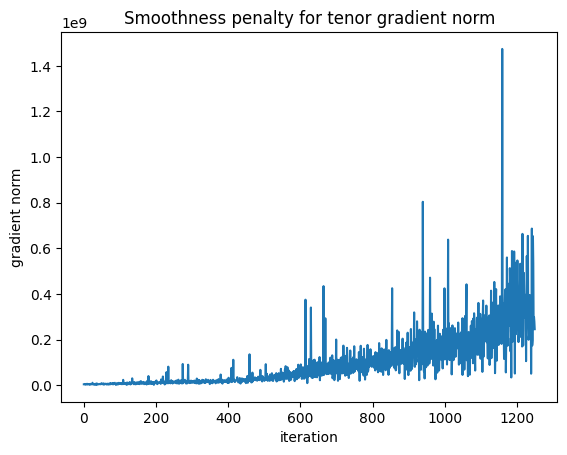

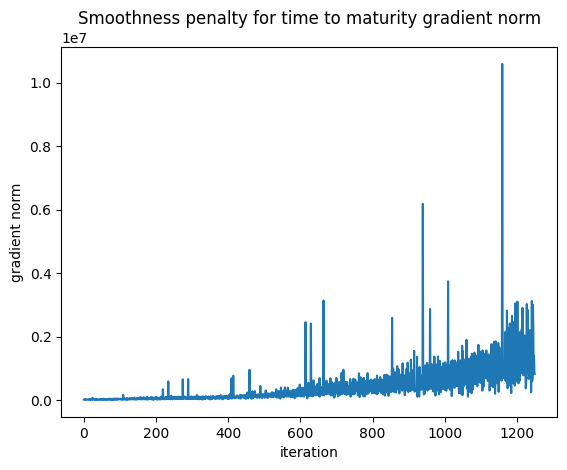

alpha : 1.0625574876823693e-07 beta : 2.795001277339509e-05


In [27]:
gen,gen_opt,disc,disc_opt,criterion, alpha, beta = VGS.GradientMatchingPlot(gen,gen_opt,disc,disc_opt,criterion,condition_train,true_train,tenor,tau,tenors,taus,n_grad,lrg,lrd,batch_size,noise_dim,device, vol_model=vol_model)

Full training with 10,000 epochs.

In [ ]:
gen, gen_opt, disc, disc_opt, true_train, true_val, true_test, condition_train, condition_val, condition_test, dates_t,  tenor, tau, tenors, taus  = VGS.VolGAN(DATA_PATH,SURFACE_PATH, tr, noise_dim = noise_dim, hidden_dim = hidden_dim, n_epochs = n_epochs,n_grad = n_grad, lrg = 0.0001, lrd = 0.0001, batch_size = 100, device = 'cpu', vol_model=vol_model)